# Preamble

Various global variables, parameters

In [ ]:
DEBUG = False
DATASET_MAX_SIZE = 1_000_000

# Data preparation

This work is using the Million Song Dataset, specifically the one with user listenings count.
It's available at http://millionsongdataset.com/tasteprofile/.
> Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, & Paul Lamere (2011). The Million Song Dataset. In Proceedings of the 12th International Conference on Music Information Retrieval (ISMIR 2011).

It consists of a huge list (48m+ entries) of triplets `(user id, song id, listnings count)`.

## Dataset parsing

Read from the text file, simple parse and convert to numpy data structures.

In [ ]:
from typing import Literal
import numpy as np

USER_MAPPING: dict[str, int] = {}
SONG_MAPPING: dict[str, int] = {}

# It's a list of tuples (user, song, listenings)
dataset_raw: list[np.ndarray[tuple[Literal[3]], np.dtype[np.int32]]] = []
with open("../../train_triplets.txt", "r") as dataset_file:
    for line in dataset_file:
        user_id, song_id, listenings = line.split("\t")

        line_vec = np.array(
            [
                USER_MAPPING.setdefault(user_id, len(USER_MAPPING)),
                SONG_MAPPING.setdefault(song_id, len(SONG_MAPPING)),
                int(listenings),
            ]
        )
        dataset_raw.append(line_vec)

        if len(dataset_raw) >= DATASET_MAX_SIZE:
            break

dataset = np.array(dataset_raw, dtype=np.float64)

## Dataset training/validation preparation

Shuffle & split into subsets.

We take 2/3 for the training, and 1/3 for validation.

In [ ]:
col_means = np.mean(dataset[:, 2], axis=0)
print(col_means)
print(dataset[:, 2])
print(col_means * np.ones(len(dataset[:, 2])))
dataset[:, 2] = (dataset[:, 2] - col_means * np.ones(len(dataset[:, 2]))) / np.std(
    dataset[:, 2], axis=0
)
print(dataset.dtype)
print(dataset[:, 2])


dataset_perm = np.random.permutation(len(dataset))
dataset_shuffled = dataset[dataset_perm]
training_set_size = int(len(dataset_shuffled) * 0.66)
training_set = dataset_shuffled[:training_set_size]
validation_set = dataset_shuffled[training_set_size:]

2.897579
[1. 1. 2. ... 2. 1. 6.]
[2.897579 2.897579 2.897579 ... 2.897579 2.897579 2.897579]
float64
[-0.29491726 -0.29491726 -0.13949962 ... -0.13949962 -0.29491726
  0.48217097]


# Learning

The method used is a Stochastic Gradient Descent (SGD), using Regularized Mean Squared Error (RMSE) as the loss function.
It corresponds to
$$
\min_{q^*,p^*} \sum_{(u,i) \in \mathcal{K}} \left(r_{ui} - q_i^Tp_u\right)^2 + \lambda\left(||q_i||^2 + ||p_u||^2\right)
$$

The overall method is taken from [Matrix Factorization Techniques for Recommender Systems
](https://ieeexplore.ieee.org/document/5197422).
> Y. Koren, R. Bell and C. Volinsky, "Matrix Factorization Techniques for Recommender Systems," in Computer, vol. 42, no. 8, pp. 30-37, Aug. 2009, doi: 10.1109/MC.2009.263. keywords: {Recommender systems;Motion pictures;Filtering;Collaboration;Sea measurements;Predictive models;Genomics;Bioinformatics;Nearest neighbor searches;Computational intelligence;Netflix Prize;Matrix factorization},



## Prepare learning

Prepare learning sets $q$ and $p$, which are random matrices of shapes $(|\mathrm{songs}|, l)$ and $(|\mathrm{users}|, l)$.

Set parameters:
- Size `l` of latent space to embed users & films
- Learning rate $\gamma$
- Regularization $\lambda$
- Number of epochs (rounds)

In [ ]:
# (Hyperparameter) Size of latent space to make the embeddings
l = 100
# Initial (random) values
# Shape: (#SONGS, l)
q = np.random.random_sample((len(SONG_MAPPING), l))
if DEBUG:
    print(q.shape, q.dtype, q)
# Shape: (#USERS, l)
p = np.random.random_sample((len(USER_MAPPING), l))
if DEBUG:
    print(p.shape, p.dtype, p)


# Training parameters
lbd = 0.001
gamma = 0.0001
n_epochs = 100

(148039, 100) float64 [[0.94865282 0.79598648 0.96194735 ... 0.15782866 0.2228748  0.92942072]
 [0.08445591 0.97846053 0.90746158 ... 0.39242941 0.89734079 0.62907015]
 [0.72466726 0.1340323  0.12758653 ... 0.20335042 0.04591881 0.24685899]
 ...
 [0.75563113 0.23112964 0.21884928 ... 0.83931071 0.59476204 0.88712244]
 [0.36894981 0.12815384 0.44279428 ... 0.58507165 0.90355031 0.91833062]
 [0.04574251 0.78667025 0.63315731 ... 0.58717919 0.7821969  0.09308236]]
(20787, 100) float64 [[0.59627296 0.80604397 0.50259388 ... 0.98947382 0.15858654 0.54293704]
 [0.52345464 0.18608639 0.28223485 ... 0.99445436 0.71739583 0.68315065]
 [0.01239116 0.22742357 0.80050528 ... 0.05029427 0.72895309 0.15143689]
 ...
 [0.52009206 0.56171457 0.48894009 ... 0.43599758 0.20878929 0.22344573]
 [0.26991265 0.73887101 0.88454376 ... 0.89865657 0.50542772 0.41030458]
 [0.31319836 0.96847159 0.49356166 ... 0.81236254 0.09580039 0.61095614]]


## Actual learning

Process the SGD, accumulating loss so it can be analyzed.

In [ ]:
losses = [np.nan] * n_epochs
losses_validation = [np.nan] * n_epochs

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    loss_sum: float = 0

    np.random.shuffle(training_set)  # Reorder each epoch
    # user \in [0, #USERS - 1]
    # song \in [0, #SONGS - 1]
    # listenings \in N (r_ui, "true" value)
    for i, (user, song, listenings) in enumerate(training_set):
        if DEBUG:
            print(
                f"Training value {i}/{len(training_set)}: ({user},{song},{listenings})"
            )

        # Predicted value
        p_u = p[int(user)].copy()
        q_i = q[int(song)].copy()
        if DEBUG:
            print(p_u)
            print(q_i)

        listenings_hat = p_u.T @ q_i
        if DEBUG:
            print(f"Prediction: {listenings_hat}")

        # Prediction error
        e_ui = listenings - listenings_hat

        # This is the learning part
        q[int(song)] += gamma * (e_ui * p_u - lbd * q_i)
        p[int(user)] += gamma * (e_ui * q_i - lbd * p_u)

        # Loss
        loss = e_ui**2 + lbd * (np.linalg.norm(q_i) ** 2 + np.linalg.norm(p_u) ** 2)
        if DEBUG:
            print(f"Loss: {loss}")
        loss_sum += loss

    losses[epoch] = loss_sum / len(training_set)

    # Now evaluating on validation data
    loss_validation_sum = 0
    for user, song, listenings in validation_set:
        listenings_hat = p[int(user)].T @ q[int(song)]

        e_ui = listenings - listenings_hat

        # Loss
        loss = e_ui**2 + lbd * (
            np.linalg.norm(q[int(song)]) ** 2 + np.linalg.norm(p[int(user)]) ** 2
        )
        loss_validation_sum += loss

    losses_validation[epoch] = loss_validation_sum / len(training_set)

    print(f"Loss: {losses[epoch]}, validation loss: {losses_validation[epoch]}")

Epoch 1
Loss: 484.10362021391654, validation loss: 198.67493810504206
Epoch 2
Loss: 325.8429417282482, validation loss: 146.90447786781857
Epoch 3
Loss: 247.3415435586282, validation loss: 116.8627332648662
Epoch 4
Loss: 198.68118025856685, validation loss: 96.96613191727286
Epoch 5
Loss: 165.26695189743756, validation loss: 82.75471087503055
Epoch 6
Loss: 140.84280937354697, validation loss: 72.08062833036107
Epoch 7
Loss: 122.20499126589307, validation loss: 63.767255101031346
Epoch 8
Loss: 107.52278350390661, validation loss: 57.11077235262843
Epoch 9
Loss: 95.66824606271247, validation loss: 51.66290725471387
Epoch 10
Loss: 85.90600270536713, validation loss: 47.12400136625958
Epoch 11
Loss: 77.73539218644258, validation loss: 43.28588770253657
Epoch 12
Loss: 70.80336528582413, validation loss: 39.99910829786487
Epoch 13
Loss: 64.85370150981383, validation loss: 37.15406684990427
Epoch 14
Loss: 59.696159611651, validation loss: 34.66830257906057
Epoch 15
Loss: 55.18638211983887, va

# Analysis

## Learning results

We first analyze the learning raw results: training and validation losses.

/tmp/cache-mdlimi/ipykernel_949394/3275969896.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


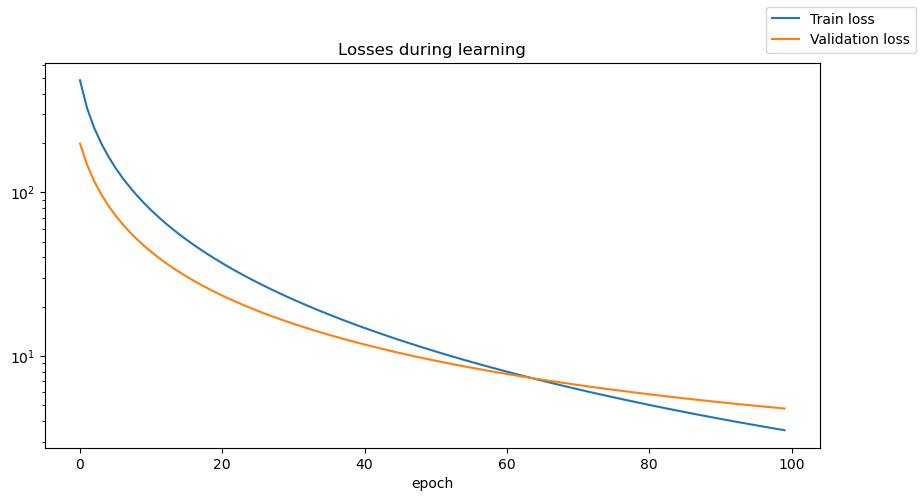

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

_ = ax.plot(losses, label="Train loss")
_ = ax.plot(losses_validation, label="Validation loss")
_ = ax.set_yscale("log")
_ = ax.set_xlabel("epoch")
_ = ax.set_title("Losses during learning")
_ = fig.legend()
fig

## ... more analysis

Evaluation of the model?